# Лабораторная обучение без учителя

Лабораторная состоит из гайда по работе с задачами машинного обучения без учителя (unsupervised learning) на Python и трёх обязательных заданий:
* [Задание 1](#Задание-1.) - понижение размерности с помощью t-SNE;
* [Задание 2](#Задание-2.) - кластеризация с фильтрацией выбросов с помощью DBSCAN;
* [Задание 3](#Задание-3.) - кластеризация вершин графа генов _Mus musculus_ с помощью MCL. За попадание в топ 3 по качеству кластеризации можно получить 1 дополнительный балл.

Сначала рекомендуется ознакомиться с гайдом, после чего выполнять задания.

---

#### Используемые модули

Обновим пакетный менеджер pip, чтобы корректно уставить необходимые модули:

In [1]:
# При необходимости добавляйте опцию --user
!pip install --upgrade pip

     ---------------------------------------- 2.1/2.1 MB 4.1 MB/s eta 0:00:00


ERROR: To modify pip, please run the following command:
C:\Users\lamba\anaconda3\python.exe -m pip install --upgrade pip


Установим необходимые модули:

In [2]:
# При необходимости добавляйте опцию --user
!pip install -r requirements.txt

  Using cached matplotlib-3.5.1-cp39-cp39-win_amd64.whl (7.2 MB)
     ---------------------------------------- 2.0/2.0 MB 5.1 MB/s eta 0:00:00
  Using cached numpy-1.21.5-cp39-cp39-win_amd64.whl (14.0 MB)
  Using cached pandas-1.4.2-cp39-cp39-win_amd64.whl (10.5 MB)
  Using cached scikit_learn-1.1.2-cp39-cp39-win_amd64.whl (7.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.2
    Uninstalling pandas-1.5.2:
      Successfully uninstalled pandas-1.5.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Attempting uninstall: scikit_learn
    

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
scikit-image 0.20.0 requires networkx>=2.8, but you have networkx 2.7.1 which is incompatible.


Подключим модули, которые пригодятся в мини-лабораторной.

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd

import os
import random
import json

from sklearn.manifold import TSNE
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cluster import KMeans, DBSCAN

import networkx as nx
import markov_clustering as mc

## 1. Понижение размерности

Одна из задач обучения без учителя (unsupervised learning) - понижение размерности.

Напомним, что идея задачи понижения размерности состоит в переходе к небольшому числу показательных (информативных) признаков, принимающих много значений - с такими признаками работать проще.

Воспользуемся методом t-SNE для понижения размерности для данных "wine" (набор данных доступен в библиотеке scikit-learn)

In [4]:
# Прочитаем данные
x_all, y_all = load_iris(return_X_y=True)
# Поделим на тренировочную и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.2, random_state=123)

print(f'Размеры выборок: тренировочная - {x_train.shape[0]}, тестовая - {x_test.shape[0]}')
print(f'Кол-во признаков: {x_train.shape[1]}')

Размеры выборок: тренировочная - 120, тестовая - 30
Кол-во признаков: 4


Обучим классификатор, основанный на _машине опорных векторов_ (support vector machine, SVM).

Метод SVM ищет параметры гиперплоскости (или гиперповерхности), которая разделяет пространство признаков данных на области, каждая область соответствует своему классу.

In [5]:
sv_clf = SVC(kernel='linear', random_state=123)
sv_clf.fit(x_train, y_train)

SVC(kernel='linear', random_state=123)

Оценим качество полученной модели

In [6]:
predictions = sv_clf.predict(x_test)
print('Accuracy score = {:.3f}'.format(accuracy_score(y_test, predictions)))
print('F1 score = {:.3f}'.format(f1_score(y_test, predictions, average='macro')))

Accuracy score = 0.967
F1 score = 0.955


Воспользуемся t-SNE в качестве предобработки данных

_Примечание:_ особенность метода t-SNE и его реализации в scikit-learn в том, что этот метод нельзя применять к новым данным, которые могут появиться на стадии предсказания обученной модели. Появление новых данных может серьёзно изменить отображение, построенное с помощью t-SNE, что является серьёзным ограничением применимости этого метода. В связи с этим, отображение t-SNE следует строить сразу и для тренировочных, и для тестовых данных

In [7]:
tsne = TSNE(n_components=2, init='random', random_state=123, learning_rate='auto')
# Так как строим отображение сразу и для тренировочных, и для тестовых данных, надо запомнить, какие из данных тренировочные
train_len = x_train.shape[0]
x_all_transformed = tsne.fit_transform(np.vstack([x_train, x_test]))
x_train_transformed = x_all_transformed[:train_len, :]  # Вытаскиваем признаки для тренировочных данных
x_test_transformed = x_all_transformed[train_len:, :]  # Остальные данные - тестовые
print(f'Кол-во признаков после предобработки: {x_train_transformed.shape[1]}')

Кол-во признаков после предобработки: 2


Визуализация данных после предобработки

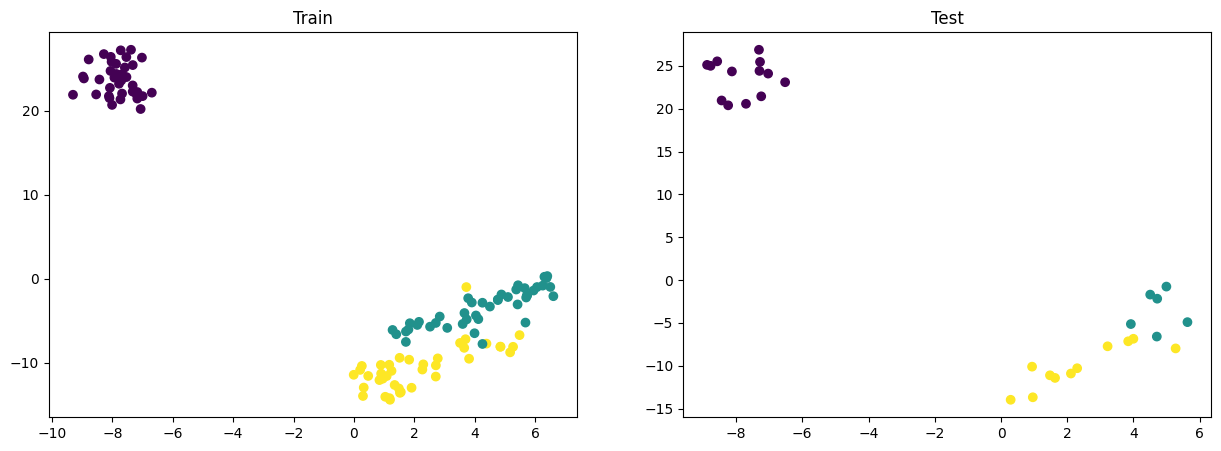

In [8]:
def show_tsne_result(x_train_new, x_test_new, y_train, y_test):
    fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
    ax[0].scatter(x_train_new[:,0], x_train_new[:,1], c=y_train)
    ax[0].set_title('Train')
    
    ax[1].scatter(x_test_new[:,0], x_test_new[:,1], c=y_test)
    ax[1].set_title('Test')
    
    plt.show()

show_tsne_result(x_train_transformed, x_test_transformed, y_train, y_test)

Обучим SVM-классификатор с линейным ядром и посмотрим, как улучшилось качество

In [9]:
sv_clf = SVC(kernel='linear', random_state=123)
sv_clf.fit(x_train_transformed, y_train)
predictions = sv_clf.predict(x_test_transformed)
print('Accuracy score = {:.3f}'.format(accuracy_score(y_test, predictions)))
print('F1 score = {:.3f}'.format(f1_score(y_test, predictions, average='macro')))

Accuracy score = 0.967
F1 score = 0.955


---

### Задание 1.

Подберите параметры `TSNE` так, чтобы SVM-классификатор с линейным ядром, обученный на предобработанных данных, давал качество по **каждой** из метрик `accuracy` и `f1` **не ниже** `0.98`. При этом параметр `n_components` оставьте равным `2`.

Когда подберёте параметры, скопируйте создание переменной `tsne` (вызов конструктора `TSNE` с подобранными параметрами и присваивание результата переменной `tsne`) в соответствующее задание курса на Stepik.

Менять можно **только** параметры `t-SNE`, менять гиперпараметры SVM-классификатора **запрещается**.

_Подсказки_:
1. Наиболее важный параметр в методе t-SNE - `perplexity`;
2. SVM с линейным ядром идеально работает, когда данные линейно разделимы - то есть, когда для каждого класса есть прямая (в нашем случае), отделяющая этот класс от остальных классов.

In [38]:
# Поменяйте параметры в TSNE.
# Когда подберёте подходящие параметры и проверите результат, скопируйте весь код этой ячейки в поле ввода
# ответа в соответствующем задании курса на Stepik.
tsne = TSNE(
    n_components=2,  # но кол-во размерностей оставьте равным 2
    init='random',
    random_state=123,
    perplexity=35.0,
    learning_rate='auto',
)

Для вычисления метрик качества и просмотра результатов выполните код ниже:

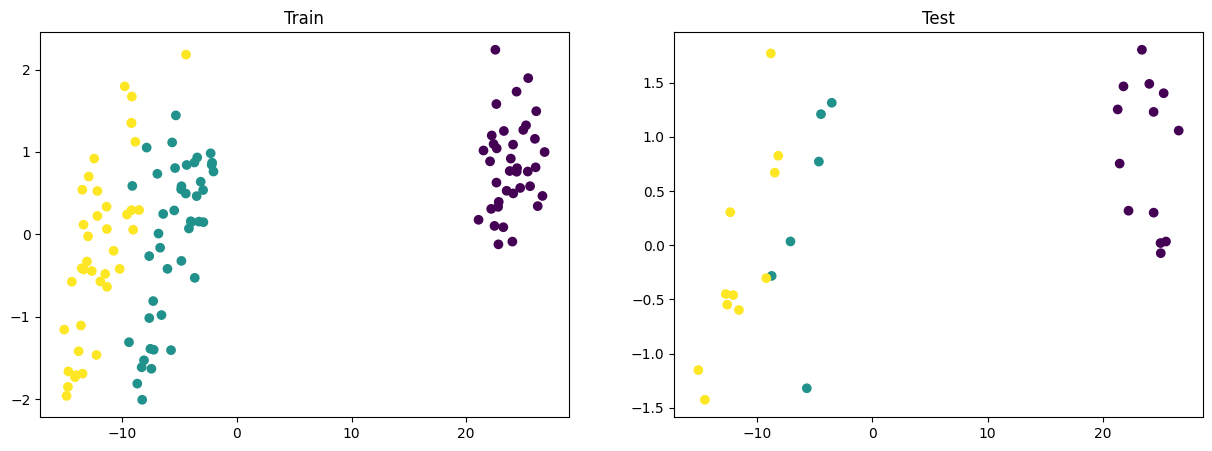

Accuracy score = 1.000
F1 score = 1.000
Требуемое качество достигнуто


In [39]:
train_len = x_train.shape[0]
x_all_transformed = tsne.fit_transform(np.vstack([x_train, x_test]))
x_train_transformed = x_all_transformed[:train_len, :]
x_test_transformed = x_all_transformed[train_len:, :]

show_tsne_result(x_train_transformed, x_test_transformed, y_train, y_test)

sv_clf = SVC(kernel='linear', random_state=123)
sv_clf.fit(x_train_transformed, y_train)
predictions = sv_clf.predict(x_test_transformed)
final_accuracy, final_f1 = accuracy_score(y_test, predictions), f1_score(y_test, predictions, average='macro')
print('Accuracy score = {:.3f}'.format(final_accuracy))
print('F1 score = {:.3f}'.format(final_f1))
if final_accuracy >= 0.98 and final_f1 >= 0.98:
    print('Требуемое качество достигнуто')
else:
    print('Требуемое качество не достигнуто')

---

## 2. Кластеризация

### K-Means

На практике случается, что надо объединить данные в группы, при этом известно количество групп. Такую задачу можно решить с помощью метода кластеризации _K-Means_ (или K-средних).

Метод пытается найти такие "центры" кластеров, чтобы минимизировать СКО внутри кластеров.

Особенности метода:
* Требуется задать кол-во кластеров
* Требуется задать начальное положение всех центров

#### Пример

Сгенерируем данные, посмотрим на них

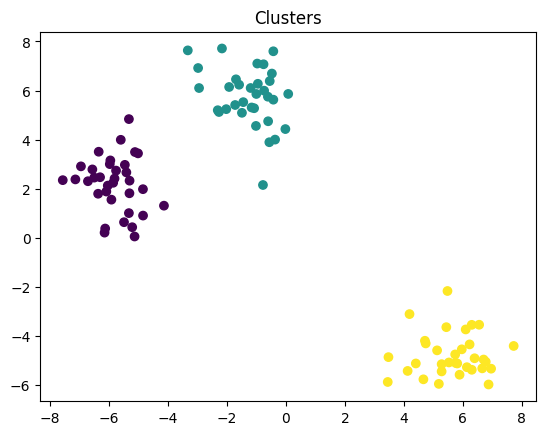

In [12]:
x_blobs, y_blobs = make_blobs(n_samples=100, centers=3, n_features=2, random_state=1234)  # Лучше не менять random_state

plt.scatter(x_blobs[:,0], x_blobs[:,1], c=y_blobs)
plt.title('Clusters')
plt.show()

По картинке видно, что данные образуют 3 группы.

Воспользуемся методом K-means, чтобы разделить данные на группы, не пользуясь информацией о метках

_Замечание_: обычно начальное положение центров кластеров задаются случайным образом, как и в случае метода `KMeans` из библиотеки scikit-learn, который использован далее

In [13]:
kmeans_clustering = KMeans(n_clusters=3, random_state=123)
kmeans_clustering.fit(x_blobs)

KMeans(n_clusters=3, random_state=123)

Посмотрим, как выполнена кластеризация

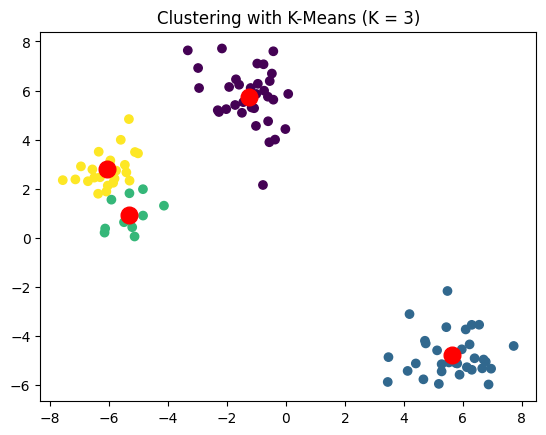

In [16]:
plt.scatter(x_blobs[:,0], x_blobs[:,1], c=kmeans_clustering.labels_)
plt.title('Clustering with K-Means (K = 3)')

cluster_centers = kmeans_clustering.cluster_centers_

# Красными точками отметим центры кластеров
plt.plot(cluster_centers[:,0], cluster_centers[:,1], 'ro', markersize=12)
plt.show()

Посмотрим, что будет, если с помощью параметра `n_clusters` задать не 3, а 4 кластера

In [17]:
kmeans_clustering = KMeans(n_clusters=4, random_state=123)
kmeans_clustering.fit(x_blobs)

KMeans(n_clusters=4, random_state=123)

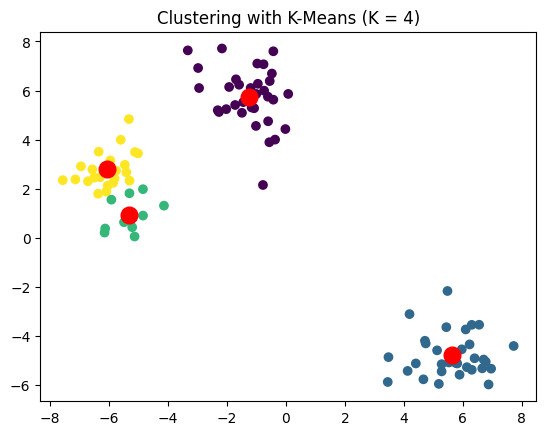

In [18]:
plt.scatter(x_blobs[:,0], x_blobs[:,1], c=kmeans_clustering.labels_)
plt.title('Clustering with K-Means (K = 4)')

cluster_centers = kmeans_clustering.cluster_centers_

# Красными точками отметим центры кластеров
plt.plot(cluster_centers[:,0], cluster_centers[:,1], 'ro', markersize=12)
plt.show()

Модель `K-means` имеет свои особенности, из-за которых она применима в задачах, где известно кол-во кластеров, и эти кластеры можно описывать шарами (это заложено в принцип обучения модели).

Если "контекст", в котором ставится задача кластеризации, подразумевает, что кластерам могут соответствовать области более сложной формы, или неизвестно кол-во кластеров, следует пользоваться другими методами.

### DBSCAN

Рассмотрим подробнее метод кластеризации _DBSCAN_.

Особенности этого метода:
* Кластерами считаются такие облака из точек, где точки находятся _достаточно близко_ друг к другу - можно находить плотные кластеры более сложной формы, чем простые шары
* Точки, у которых "нет соседей", можно считать выбросами

#### Пример

Сгенерируем данные в виде прямоугольной области и "кольца" около этой области

In [19]:
np.random.seed(123)

# Данные для первого кластера - "квадрат"
cluster_1 = np.random.uniform(-2, 2, (300, 2))

# Данные для второго кластера - "кольцо".
# Для достижения "формы кольца" семплируем точки из равномерного распределения
# в прямоугольнике в полярных координатах, потом переводим полярные координаты
# в декартовы по известным формулам
cluster_2_phi = np.random.uniform(-np.pi, np.pi, 350)
cluster_2_r = np.random.uniform(4, 5, 350)
cluster_2_x, cluster_2_y = cluster_2_r * np.cos(cluster_2_phi), cluster_2_r * np.sin(cluster_2_phi)
cluster_2 = np.vstack([cluster_2_x, cluster_2_y]).transpose(1, 0)

# Объединяем данные в единый массив
clusters = np.vstack([cluster_1, cluster_2])

Посмотрим на данные

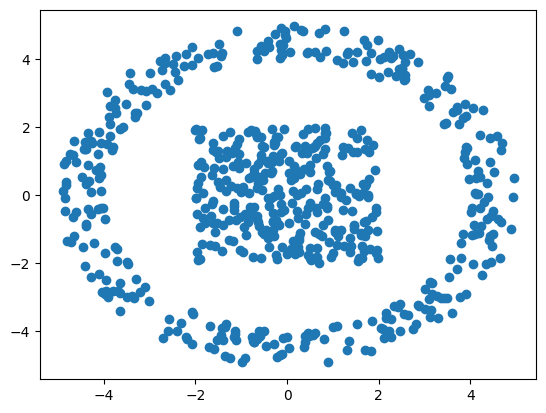

In [20]:
plt.scatter(clusters[:,0], clusters[:,1])
plt.show()

Построим кластеризацию с помощью `KMeans` и `DBSCAN`.

Ожидаем, что KMeans не сможет отличить кольцо от прямоугольника, а DBSCAN сможет

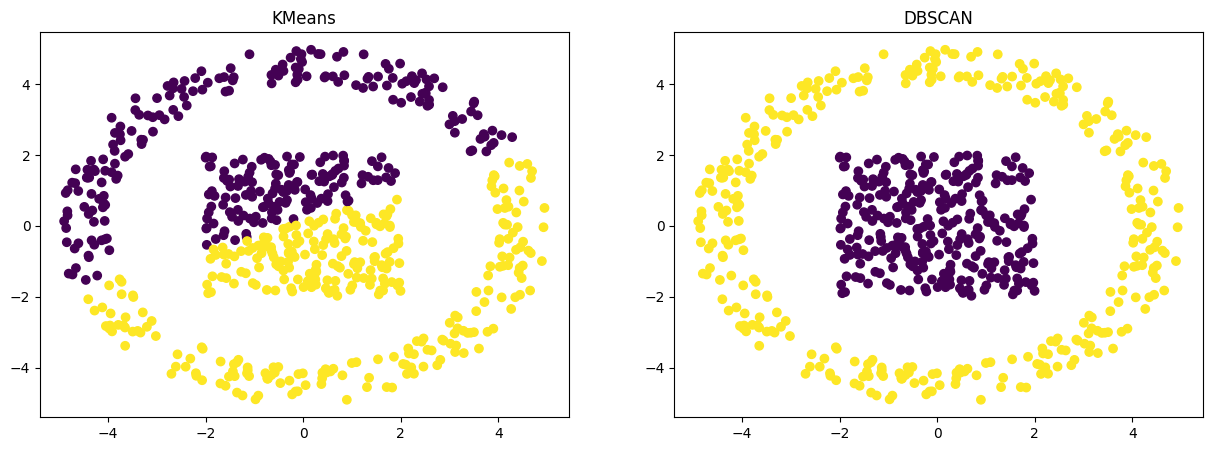

In [21]:
kmeans = KMeans(n_clusters=2, random_state=123).fit(clusters)
dbscan = DBSCAN(eps=1, min_samples=10).fit(clusters)

fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

for i, (method, name) in enumerate(zip((kmeans, dbscan), ("KMeans", "DBSCAN"))):
    ax[i].scatter(clusters[:,0], clusters[:,1], c=method.labels_)
    ax[i].set_title(name)

plt.show()

---
### Задание 2.

Ниже заново будет создан массив входных данных похожим образом, но с добавлением "выбросов".

Произведите кластеризацию таким образом, чтобы "выбросы" были зафиксированы, но при этом кластеры "не распадались" на более мелкие компоненты. Следует подбирать **следующие параметры** конструктора `DBSCAN`: `eps`, `min_samples`.

Требуется найти такие параметры, при которых данные разбиваются на кластеры в соответствии с тем, как они сгенерированы (кластеров в итоге оказывается 2, и объекты в них соответствуют исходному разбиению объектов на кластеры), при этом "выбросы" верно определяются (выбросов определяется столько, сколько их было добавлено в исходные данные; никакой объект, не являвшийся выбросом при генерации, не помечается выбросом в результате работы алгоритма DBSCAN).

Скопируйте инициализацию переменной `dbscan` результатом вызова конструктора `DBSCAN` с подобранными параметрами в поле ввода ответа в соответствующем задании курса на Stepik.

_Подсказки_:
1. Если кластер распадается на множество кластеров, можно увеличивать eps (макс. расстояние между объектами кластера);
2. Если кластер вбирает в себя много лишних точек, можно уменьшать eps;
3. Чтобы несколько стоящих рядом выбросов не объединялись в целый кластер, можно увеличивать min_samples.

In [70]:
# Поменяйте параметры в DBSCAN.
# Когда подберёте параметры и проверите результат, скопируйте содержимое этой ячейки
# в поле ввода ответа в соответствующем задании курса на Stepik
dbscan = DBSCAN(
    eps=0.5,
    min_samples=5,
)

Для просмотра результатов и их самопроверки выполните код ниже:

Задание выполнено верно


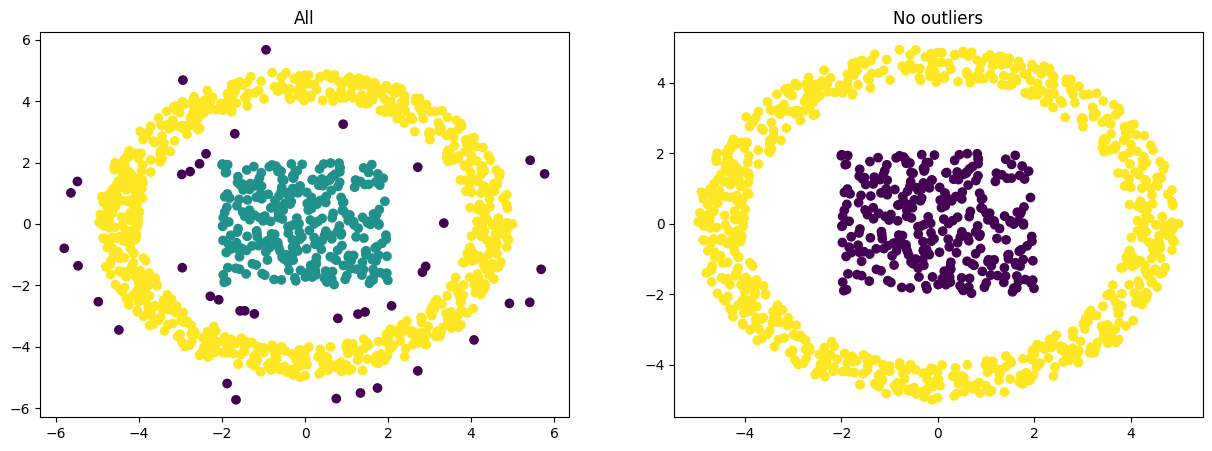

In [71]:
np.random.seed(123)  # Для воспроизводимости

# Данные для первого кластера - "квадрат"
cluster_1_size = 300
cluster_1 = np.random.uniform(-2, 2, (cluster_1_size, 2))

# Данные для второго кластера - "кольцо"
cluster_2_size = 800
cluster_2_phi = np.random.uniform(-np.pi, np.pi, cluster_2_size)
cluster_2_r = np.random.uniform(4, 5, cluster_2_size)
cluster_2_x, cluster_2_y = cluster_2_r * np.cos(cluster_2_phi), cluster_2_r * np.sin(cluster_2_phi)
cluster_2 = np.vstack([cluster_2_x, cluster_2_y]).transpose(1, 0)

# Данные для "выбросов". Так как хотим, чтобы "выбросы" не попадали
# в исходные кластеры, генерируем их в двух кольцах, которые не
# пересекаются с областями исходных кластеров
outliers_size = 40
cluster_outliers_phi = np.random.uniform(-np.pi, np.pi + 0.1, 40)
cluster_outliers_r = np.hstack([np.random.uniform(3.15, 3.4, 20), np.random.uniform(5.5, 6, 20)])
outliers_x, outliers_y = cluster_outliers_r * np.cos(cluster_outliers_phi), cluster_outliers_r * np.sin(cluster_outliers_phi)
outliers = np.vstack([outliers_x, outliers_y]).transpose(1, 0)

# Объединяем всё в один массив
clusters = np.vstack([cluster_1, cluster_2, outliers])

'''
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(clusters)
distances, indices = neighbors_fit.kneighbors(clusters)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
'''


# Проводим кластеризацию
dbscan = dbscan.fit(clusters)

# Создаём метки кластеров, -1 соответствует выбросам.
# Так как данные не перемешаны, первые cluster_1_size элементов относятся к первому кластеру,
# следующие cluster_2_size элементов - ко второму.
clusters_labels = [0] * cluster_1_size + [1] * cluster_2_size + [-1] * outliers_size


# Проверяем результат кластеризации. Выбросы помечены -1
outliers_len_ans = len(clusters[dbscan.labels_ == -1])
clustering_labels = set(dbscan.labels_)
clustering_labels.remove(-1)
if len(clustering_labels) != 2:
    print("Получено неверное кол-во кластеров (требуется 2 получить кластера и выбросы)")
elif outliers_len_ans > outliers.shape[0]:
    print(f"Среди выбросов есть объекты, не являющиеся выбросами")
elif outliers_len_ans < outliers.shape[0]:
    print(f"Выделены не все выбросы")
else:
    # Проверим, совпадают ли кластеры с классами
    clusters_match = True
    for label in clustering_labels:
        clusters_match = clusters_match and len(set(np.array(clusters_labels)[dbscan.labels_ == label])) == 1
    if clusters_match:
        print("Задание выполнено верно")
    else:
        print("Выбросы отобраны верно, но полученные кластеры не соответствуют исходным данным")
        

# Отрисовка результатов, 2 графика: исходное распределение и кластеризация с отбрасыванием "выбросов"
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

ax[0].scatter(clusters[:,0], clusters[:,1], c=clusters_labels)
ax[0].set_title('All')

# На втором графике отрисовываем кластеры, выкидывая выбросы
clusters_no_outliers = clusters[dbscan.labels_ != -1,:]
ax[1].scatter(clusters_no_outliers[:,0], clusters_no_outliers[:,1], c=dbscan.labels_[dbscan.labels_ != -1])
ax[1].set_title('No outliers')

plt.show()


---

### MCL

Еще один интересный алгоритм кластеризации - _MCL algorithm - Markov Cluster Algorithm_ на основе графов.

Метод опирается на следующие утверджения:
* Расстояние между узлами графа, относящимися к одному кластеру, меньше, чем расстояниме между узлами, относящимися к различным кластерам
* При случайном обходе графа, прежде чем покинуть кластер, будут посещены многие из его вершин
* Края между кластерами вероятнее всего находятся на кратчайших путях

Особенности метода:

* Может работать с взвешенными и невзвешенными графами
* Может находить кластеры произвольной формы
* Не умеет находить перекрывающиеся кластеры
* Кластеры могут быть разного размера

Подробнее можно прочитать тут: https://micans.org/mcl/

Для того, чтобы воспользоваться алгоритмом, дополнительно установим библиотеку `markov-clustering`:

#### Пример

Посмотрим, как алгоритм будет работать на модельных данных. Сгенерируем случайный граф с помощью библиотеки `networkx`:

In [24]:
!pip install networkx==2.6 --user

     ---------------------------------------- 1.9/1.9 MB 4.5 MB/s eta 0:00:00


Reason for being yanked: Need to resolve: https://github.com/networkx/networkx/pull/4967
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.20.0 requires networkx>=2.8, but you have networkx 2.6 which is incompatible.


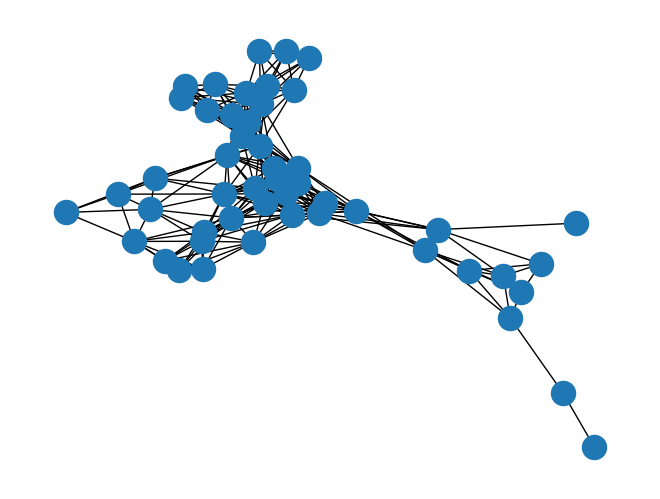

In [25]:
# задаем нужное количество вершин
nodesnum = 50

# генерируем граф
graph = nx.random_geometric_graph(nodesnum, radius = 0.3)

# получаем матрицу смежности из сгенерированного графа
matrix = nx.to_scipy_sparse_array(graph)

# получаем расположение узлов сгенерированного графа
positions = nx.spring_layout(graph)

#нарисуем получившийся граф
nx.draw(graph, pos = positions)

Применим марковский алгоритм кластеризации:

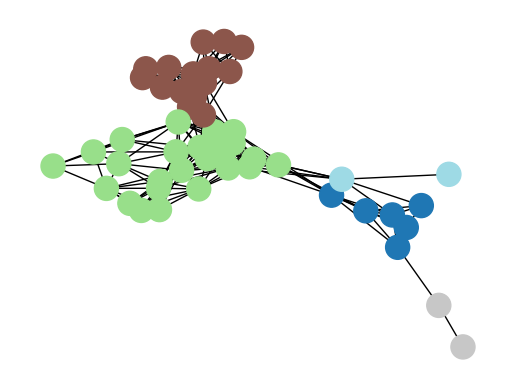

CPU times: total: 15.6 ms
Wall time: 98.1 ms


In [26]:
%%time

# получаем результат кластеризации
result = mc.run_mcl(matrix)

# выделяем получившиеся кластеры
clusters = mc.get_clusters(result)

# отрисовываем граф с результатами кластеризации
mc.draw_graph(matrix, clusters, pos = positions, with_labels = False)

Одной из наиболее популярных метрик оценки качества кластеризации на графах является __модулярность__.

Модулярность представляет собой меру "неслучайности" полученных кластеров.

Пусть $k_i$ - степень вершины $i$,  
$m$ - число ребер в графе,  
$A$ - матрица смежности, содержащая веса ребер,  
$c_i$ - кластер, к которому относится вершина $i$,  
$\delta(i,j) = 1$ при $c_i=c_j$, иначе $0$.  
Допустим, мы перемещаем ребра, сохраняя распределение степеней. Тогда грубая оценка вероятности того, что $i$ и $j$ будут соединены, равняется: $\cfrac{k_ik_j}{2m}$.

Тогда __модулярность__ - мера "неслучайнсости" - рассчитывается следующим образом:
$$Q = \cfrac{1}{2m}\sum_{i, j}\left[A_{i, j} - \cfrac{k_ik_j}{2m}\right]\delta(c_i, c_j)$$

Чем выше значение величины модулярности, тем лучше качество кластеризации. Модулярность лежит в интервале от $-1$ до $1$.

Посчитаем модулярность нашего варианта кластеризации:

In [27]:
Q = mc.modularity(matrix = result, clusters = clusters)
print('Modularity score = {:.3f}'.format(Q))

Modularity score = 0.562


## Рассмотрим [данные](https://www.omicsdi.org/dataset/geo/GSE10246) об эксперссии генов мышей. Был построен граф генов _Mus musculus_, где вершинами являются сами гены, а взвешенные ребра показывают отношение их коэкспрессии друг к другу.   
Загрузим получившийся граф и посмотрим на него:

CPU times: total: 1.31 s
Wall time: 2.94 s


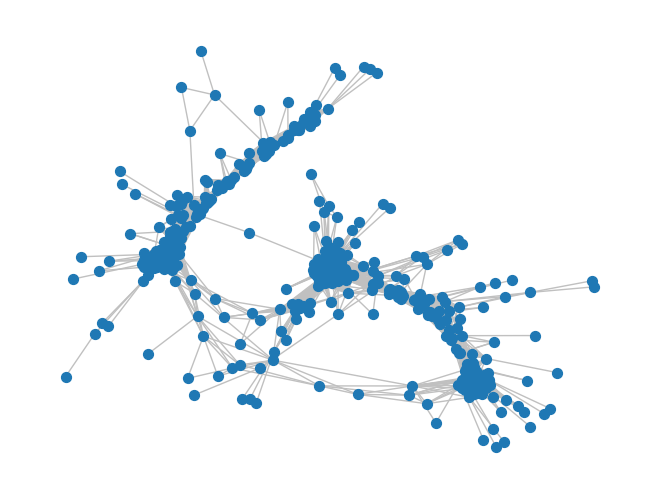

In [28]:
%%time

# считываем датасет
G = pd.read_csv(os.path.join("data", "task3.csv"), sep=";", header=None)

# создаем граф
graph = nx.Graph()

for i in range(len(G)):
    graph.add_edge(G[0][i], G[1][i], weight = G[2][i])

# получаем матрицу смежности для данного графа
matr = nx.to_scipy_sparse_array(graph)

# получаем расположение узлов графа генов
p = nx.spring_layout(graph, seed=123)
 
# отрисовываем граф
nx.draw(graph, pos=p, node_size=50, edge_color="silver")

---

### Задание 3.

Проведите кластеризацию с помощью марковского алгоритма так, чтобы модулярность оказалась **не ниже** `0.796`.

Для этого изменяйте параметры алгоритма - функции `run_mcl`.
Результат кластеризации окажется в переменной `clusters` - этот результат надо передать в Stepik, для этого:
* Выполните последнюю ячейку с кодом, в которой происходит сериализация `clusters` в JSON-строку и печать этой строки;
* Скопируйте вывод той ячейки и вставьте в поле ввода ответа в соответствующем задании курса на Stepik.

_Наиболее важные параметры:_
* `expansion > 1`, целое - "расширение" матрицы - то есть степень, в которую будет возводиться матрица смежности
* `inflation > 1`, вещественное - "инфляция" матрицы - то есть степень, в которую будет возведен каждый элемент матрицы

Другие параметры:
* `loop_value >=0` - значение, присваемое в матрице смежности для переходов из вершины в саму себя
* `iterations > 0` - количество итераций алгоритма. Если будет достигнута сходимость, итераций может быть меньше указанных
* `pruning_treshold >= 0` - если значение в матрице становится меньше данного, оно заменяется на 0

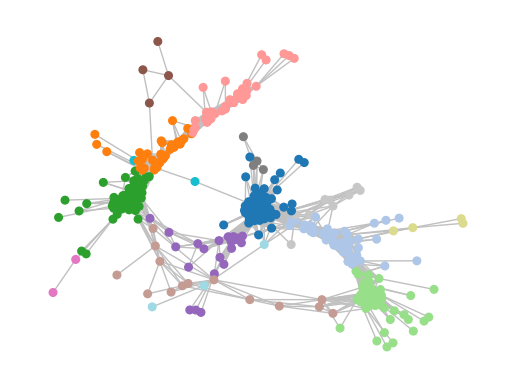

In [106]:
res = mc.run_mcl(
    matr,
    # Эти параметры можно менять
    expansion=3,
    inflation=2.4,
    loop_value=0.9,
    iterations=100,
    pruning_threshold=0.001,
)

# выделяем получившиеся кластеры
clusters = mc.get_clusters(res)

# отрисовываем граф с результатами кластеризации
mc.draw_graph(graph, clusters, pos=p, with_labels = False, node_size=30, edge_color="silver")

In [107]:
# Вычисляем модулярность
Q = mc.modularity(matrix = res, clusters = clusters)
print('Modularity score = {:.5f}'.format(Q))
print('Требуемое качество достигнуто' if Q >= 0.796 else 'Требуемое качество не достигнуто')

Modularity score = 0.79707
Требуемое качество достигнуто


Когда требуемое качество кластеризации достигнуто, выполните ячейку ниже, её результат (вывод) скопируйте и вставьте в поле ввода ответа в соответствующем задании курса на Stepik

In [109]:
print(f"clusters = {json.dumps(clusters)}")

clusters = [[0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 20, 22, 23, 24, 25, 30, 31, 32, 33, 34, 36, 37, 40, 41, 44, 45, 46, 47, 48, 49, 50, 51, 55, 56, 57, 58, 63, 64, 67, 70, 71, 72, 75, 76, 79, 80, 85, 88, 89, 90, 93, 94, 95, 96, 97, 98, 100, 101, 103, 104, 106, 107, 108, 109, 110, 111, 116, 117, 118, 119, 120, 121, 124, 125, 126, 129, 130, 135, 138, 141, 142, 143, 144, 145, 146, 147, 148, 151, 152, 153, 156, 157, 158, 160, 163, 165, 166, 169, 171, 172, 173, 180, 181, 184, 185, 193, 194, 195, 196, 197, 204, 205, 208, 215, 221, 222, 223, 227, 229, 231, 235, 236, 240, 243, 244, 248, 249, 253, 255, 265, 269, 272, 273, 274, 282, 283, 284, 287, 288, 290, 297, 301, 302, 304, 305, 312, 313, 323, 331, 332, 337, 340, 344, 356, 364, 370, 406, 418, 429, 445, 451, 459, 467, 474, 476, 511, 520], [2, 3, 21, 42, 43, 54, 105, 167, 168, 170, 189, 190, 212, 213, 260, 263, 264, 267, 280, 298, 318, 326, 328, 338, 343, 349, 353, 354, 358, 359, 360, 377, 386, 387, 390, 393, 399, 404, 407, 417, 421, 425, 436,